# Generate ROC charts for Gradient Boosted Model
---
Using the parameters from the grid search results with the highest quadratic weighted kappa score, create AUC-ROC charts and investigate the differences between the OvR and OvO methods to binarize multi-class classification models.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score, auc, roc_curve
from itertools import cycle

import time

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# The 'ID' feature is already dropped from cleaning notebook

# Open all source files as a pd dataframe
# This dataset will be used to train the gradient boosted model
orig_train = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/train.csv')

#This dataset will be used to evaluate again the Kaggle compitition entry submission
orig_test = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/test.csv')

# Addition datasets to explore the GradBoost model on actual wine data
red_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/red_white_data_noID.csv')
white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/white_data_noID.csv')
red_white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/red_white_data_noID.csv')
trainable_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/trainable_data_noID.csv')

# Drop 'ID' columns
orig_test = orig_test.drop(columns='Id')
orig_train = orig_train.drop(columns='Id')

# Create a place to save any generated files
gb_output_path = os.path.join(os.getcwd(),'grad boost output')
os.makedirs(gb_output_path, exist_ok = True)

In [3]:
# Split the data into training and testing sets
X_train = orig_train.drop('quality', axis=1)
y_train = orig_train['quality'].copy()
X_test = orig_test.copy()
quality_rating = list(y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  stratify= quality_rating,
                                                  test_size = 0.2, 
                                                  random_state = 42) #because it is the answer :)

# Define Models based on Previous Parameter Grid Searches
Define the models using the parameters that provided the highest quadratic kappa score

In [4]:
# Create a Gradient Boosting Regressor
model = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [30],
    'learning_rate': [0.05],
    'max_depth': [2]
}

# Use stratified k-fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=skfold, verbose=3)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_gb = grid_search.best_estimator_
grid_search_time = time.time()

# Make predictions on the test data using the best model
y_pred = best_gb.predict(X_val)
y_score = best_gb.predict_proba(X_val) # this line is needed to create ROC charts

# Report how long it took to complete Grid search and prediction
end_time = time.time()
grid_time = grid_search_time - start_time
pred_time = end_time - grid_search_time
tot_time = end_time - start_time

print(f"Time to complete Grid Search: {grid_time:.6f} seconds")
print(f"Time to complete prediction: {pred_time:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time:.6f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.05, max_depth=2, n_estimators=30;, score=0.565 total time=   0.4s
[CV 2/5] END learning_rate=0.05, max_depth=2, n_estimators=30;, score=0.559 total time=   0.4s
[CV 3/5] END learning_rate=0.05, max_depth=2, n_estimators=30;, score=0.587 total time=   0.4s
[CV 4/5] END learning_rate=0.05, max_depth=2, n_estimators=30;, score=0.614 total time=   0.4s
[CV 5/5] END learning_rate=0.05, max_depth=2, n_estimators=30;, score=0.561 total time=   0.4s
Time to complete Grid Search: 2.326932 seconds
Time to complete prediction: 0.005587 seconds
Total time to complete Grid Search and prediction: 2.332519 seconds


In [5]:
# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1 = f1_score(y_val, y_pred, average= 'weighted')
precision = precision_score(y_val, y_pred, average= 'weighted')
recall = recall_score(y_val, y_pred, average= 'weighted')
kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

print(f"Fourth model scores with stratify and skf:")
print("-------------------")
print(f"Best Estimators: {best_gb.n_estimators}")
print(f"Best Learning Rate: {best_gb.learning_rate}")
print(f"Best Max Depth: {best_gb.max_depth}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Cohen Kappa Score, quadratic weighted: {kappa:.4f}")

Fourth model scores with stratify and skf:
-------------------
Best Estimators: 30
Best Learning Rate: 0.05
Best Max Depth: 2
Accuracy: 0.62
F1: 0.61
Precision: 0.60
Recall: 0.62
Cohen Kappa Score, quadratic weighted: 0.5306


# Summary Reports
* Defined parameters
* Classification report
* Quadtratic weighted kappa score
* Time to run model

In [6]:
print("--------------------------------------------------------")
print(f"Gradient Boost Model with stratify and statified k-fold activated:")
print(f"     Learning Rate =   {best_gb.learning_rate}")
print(f"     Number of Trees = {best_gb.n_estimators}")
print(f"     Max Tree Depth =  {best_gb.max_depth}")
print("--------------------------------------------------------")
print(f"Classification Report")
print(classification_report(y_val,y_pred))
print("--------------------------------------------------------")
print(f"Quadratic Weighted Kappa Score: {kappa:.4f}")
print("--------------------------------------------------------")
print()
print(f"Time to complete run model: {grid_time:.6f} seconds")
print(f"Time to complete prediction: {pred_time:.6f} seconds")
print(f"Total time to complete model and prediction: {tot_time:.6f} seconds")
print()
print("--------------------------------------------------------")

--------------------------------------------------------
Gradient Boost Model with stratify and statified k-fold activated:
     Learning Rate =   0.05
     Number of Trees = 30
     Max Tree Depth =  2
--------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.71      0.73      0.72       168
           6       0.56      0.69      0.61       156
           7       0.58      0.42      0.49        67
           8       0.00      0.00      0.00         8

    accuracy                           0.62       412
   macro avg       0.31      0.30      0.30       412
weighted avg       0.60      0.62      0.61       412

--------------------------------------------------------
Quadratic Weighted Kappa Score: 0.5306
--------------------------------------------------------

Time to complete run 

# Generate ROC Charts
Using the model results above, generate area under the curve (AUC) ROC charts with the OvR and OvO multi-class binarization stratagies.
* Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [7]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
label_binarizer = LabelBinarizer().fit(y_train)
label_binarizer_t = label_binarizer.transform(y_val)
label_binarizer_t.shape # (n_samples, n_classes)

(412, 6)

In [8]:
interest = 5
class_id = np.flatnonzero(label_binarizer.classes_ == interest)[0]
print(f"Assigned index for quality {interest} is: {class_id}")

Assigned index for quality 5 is: 2


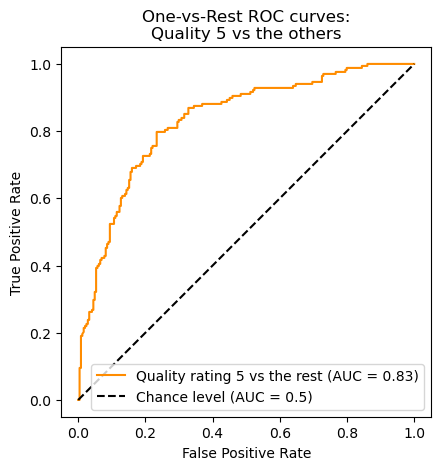

In [9]:
RocCurveDisplay.from_predictions(
    label_binarizer_t[:, class_id],
    y_score[:, class_id],
    name=f"Quality rating {interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"One-vs-Rest ROC curves:\nQuality {interest} vs the others")
plt.legend()
plt.show()

In [10]:
print(f"y_score:\n{y_score[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score[0:2,:].ravel()}")

y_score:
[[0.00299646 0.01706236 0.16870979 0.53746342 0.25505876 0.01870922]
 [0.00243591 0.01936838 0.29773069 0.4020251  0.24418661 0.03425331]]

y_score.ravel():
[0.00299646 0.01706236 0.16870979 0.53746342 0.25505876 0.01870922
 0.00243591 0.01936838 0.29773069 0.4020251  0.24418661 0.03425331]


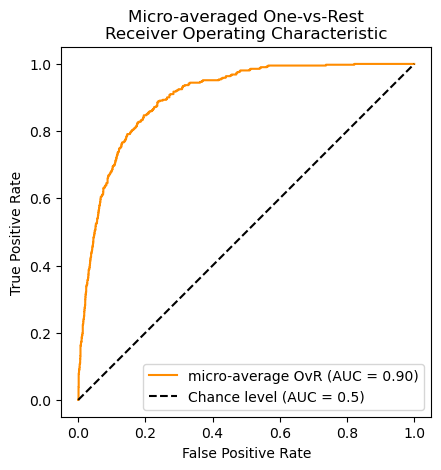

In [11]:
RocCurveDisplay.from_predictions(
    label_binarizer_t.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [12]:
micro_roc_auc_ovr = roc_auc_score(
    y_val,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.90


In [13]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarizer_t.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.90


In [14]:
n_classes = len(np.unique(y_train))


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_binarizer_t[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.82


In [15]:
macro_roc_auc_ovr = roc_auc_score(
    y_val,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.82


In [21]:
scores = np.array(np.unique(y_train))
scores

array([3, 4, 5, 6, 7, 8])

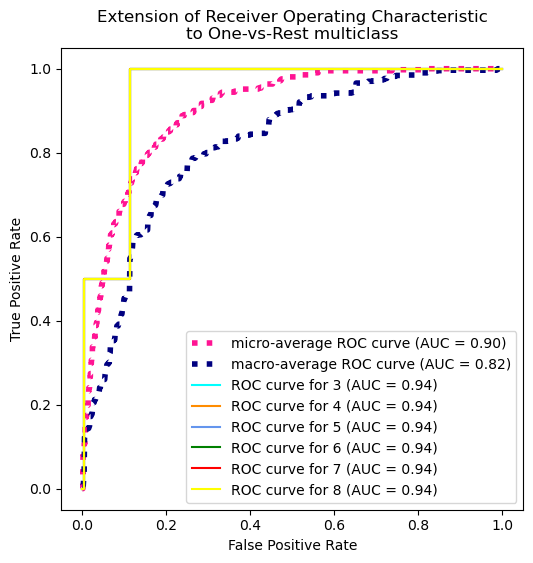

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))


plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue","green","red","yellow"])
for score, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        label_binarizer_t[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {scores[score]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()
target_names = iris.target_names
X, y = iris.data, iris.target
y = iris.target_names[y]

random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)
(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)

In [21]:
target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [26]:
qwe = np.array([1,2,3,4,5])

In [27]:
qwe

array([1, 2, 3, 4, 5])